# Predict residence time based on scavenging fields

$$ \frac{\partial [dPb]}{\partial t} = - (\beta \cdot P_{litho,authigenic} + (1-\beta) \cdot P_{biogenic} ) \cdot k_{p} \cdot [dPb] $$

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
import cmocean
import pickle
from matplotlib.colors import ListedColormap

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
jsize = jmax-jmin
isize = imax-imin

# Colors:
land_color  = '#a9a7a2'
g           = '#c1c1c1'
markers     = ["o","s","<",">","v","P","3","^","*","D", "d"]
colors      = ['#b3cde0','#005b96','#b5754c','#dbd3ce','#c36f79','#a2444f']

#### Load files:

In [3]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile    = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon = mfile['nav_lon'].values
mesh_lat = mfile['nav_lat'].values
mask     = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values
mesh_dz      = np.diff(mesh_depth, prepend=0)

# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = mesh['hdept'].values[0,:,:]

In [4]:
# Observed Pb residence times:
# Pb residence time estimates from the literature: 
# integrations were performed simply by dividing the water column into intervals defined by the midpoints between sampling depths 
# and weighting each data point according to the depth interval it represented,

#-----------------------------------------------------------------------------------------------------------
# Kadko et al., 2018: collected August 20 - October 5, 2015 ---- residence time of dissolved Pb
kadko_lats      = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                  76.505, 73.506, 73.008])
kadko_lons      = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
                  -149.515, -156.808, -158.729])
kadko_depths    = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res       = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])
# Residence times are average based on the surface to the given depth, so calculate the average depth:
kadko_ave_depth = (kadko_depths + 0) / 2.
#-----------------------------------------------------------------------------------------------------------
# Chen et al., 2012: Chukchi Sea / Bering Strait ---- residence time of Pb-210
chen_lats   = np.array([69.996, 73.998, 68.919, 70.495, 71.579, 71.261, 73.995, 73.380])
chen_lons   = np.array([-168.999, -168.991, -167.009, -162.976, -164.013, -150.376, -156.332, -151.883])
chen_depth  = np.array([30,40,10,30,40,20,30,100])
chen_res    = np.array([17,37,5,54,11,36,85,103])/365. # given initially in units of days
# Average depth based on average of sampled depths listed in table 1
chen_ave_depth = np.array([13, 23.3, 5, 15, 22, 10, 15, 50])
#-----------------------------------------------------------------------------------------------------------
# Moore and Smith, 1986: Arctic Ocean ---- residence time of dissolved Pb-210
MS_ave_depth = [130., (50+0)/2., (1200+255)/2.] # first number is in the nutrient maximum
MS_restime   = [1.5, 5, 21] 

#-----------------------------------------------------------------------------------------------------------
# Smith et al., 2003: Arctic Ocean ---- residence time of dissolved Pb-210
smith_ave_depth = [(0+50)/2., (0+50)/2., (10+25+50)/3., (10+25+40+50)/4., (10+44)/2., (2000+2000+410)/3.]
smith_restime   = [0.1, 2.2, 0.3, 0.3, 1.0, 30] # range of values observed

#-----------------------------------------------------------------------------------------------------------
# Nozaki et al., 1976: Pacific Ocean ---- residence time of Pb-210
nozaki_restime   = [1.7]    
nozaki_ave_depth = [10./2]  # don't specify the depth in paper other than surface  
 
#-----------------------------------------------------------------------------------------------------------
# Nozaki et al., 1996: Bering Sea ---- residence time of Pb-210
Nozaki_1996_ave_depth = [(1442+1922+2588+3069+3547)/5., (1000+1250+1500+1750+2000+2250+2510+2963+3209+3456+3703+3950+4328+4576+4825+5073+5322+5570)/18.]
Nozaki_1996_restime   = [10, 52]

#-----------------------------------------------------------------------------------------------------------
# Chung and Craig, 1983: North Pacific  ---- residence time of Pb-210
Chung_ave_depth = [610, 3260, 4760]
Chung_restime   = [28, 52, 32]

#-----------------------------------------------------------------------------------------------------------
# Cochran et al., 1995: Arctic ---- residence time of Pb-210
Cochran_1995_ave_depth = [(1500+3000)/2.]
Cochran_1995_restime   = [19]

#-----------------------------------------------------------------------------------------------------------
# Cochran et al., 1990: North Atlantic and North Pacific ---- residence time of Pb-210
Cochran_1990_ave_depth = [(6092+0)/2., (3718+0)/2., (3324+0)/2., (3850+0)/2., (4476+0)/2., (2184+0)/2.]
Cochran_1990_restime   = [91, 30, 42, 48, 36, 22] # first value is north pacific

#-----------------------------------------------------------------------------------------------------------
# Baskaran et al., 2022: Arctic Ocean ---- residence time of total Pb-210
baskaran_2022_ave_depth = [(3925)/2., (2166)/2., (3781)/2., (1601)/2., (500)/2., (500)/2., (500)/2., (500)/2., (500)/2., (1919+2219)/2., (3517+3817)/2.]
baskaran_2022_restime   = [149, 60, 23, 11.2, 6.9, 4.9, 5.5, 4.6, 6.2, 21, 41]
# use station 48 and 56 for spatial tuning too!

#-----------------------------------------------------------------------------------------------------------
# Wangjiang et al., 2014: Arctic Ocean ---- residence time of dissolved Pb-210, sampled 2008, not certain about trustworthiness
wangjiang_2014_lons      = [-168-(59.1/60), -161-(58.9/60), -158-(57.69/60), -158-(19.5/60), -151-(59.7/60), -147-(3.36/60)]
wangjiang_2014_lats      = [71+(59.87/60), 71+(29.17/60), 72+(30.7/60), 72+(56.3/60), 74+(59.7/60), 85+(7.83/60)]
wangjiang_2014_ave_depth = [(40+0)/2.,(40+0)/2.,(40+0)/2.,(60+0)/2.,(60+0)/2.,(60+0)/2.]
wangjiang_2014_restime   = [1.06, 2.28, 1.09, 1.70, 7.49, 5.57]

Load particle fields

In [5]:
# BLING:
folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM101/'
dset          = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/BLING-EPM101/ANHA4-EPM101_y2002m08d13_gridB.nc')
ANHA4_lons    = dset['nav_lon'].values
ANHA4_lats    = dset['nav_lat'].values
ANHA4_depths  = dset['deptht'].values

# Mn for surface particle field:
dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/Mn-extended-domain-202210/oMn_y2002m01.nc')
ANHA12_lons = mesh_lon[imin:imax,jmin:jmax]
ANHA12_lats = mesh_lat[imin:imax,jmin:jmax]

# Forcing fields:
year  = 2002
oMn   = np.zeros((12,len(mesh_depth),isize,jsize)); fpop  = np.zeros((12,len(mesh_depth),isize,jsize));
fpops = np.zeros((12,len(mesh_depth),isize,jsize)); biom  = np.zeros((12,len(mesh_depth),isize,jsize));
for month in range(1,13):
    df = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/data/Pb-tuning-202302/base/Pb_scavenging_y{year}m{month:02}.nc')
    oMn[month-1,:,:,:]   = df['oxidisMn'].values[:,imin:imax,jmin:jmax]
    fpop[month-1,:,:,:]  = df['fpop'].values[:,imin:imax,jmin:jmax]
    fpops[month-1,:,:,:] = df['fpop-sink'].values[:,imin:imax,jmin:jmax]
    biom[month-1,:,:,:]  = df['biomass'].values[:,imin:imax,jmin:jmax]

#### Functions

In [6]:
def load_monthly_comp(folder, year, month):
    # Load file of monthly average:    
    comp = xr.open_dataset(f'{folder}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc')

    dpb      = comp['dissolpb'].values[0,:,:,:] # dissolved Pb concentration
    dpb_ads  = comp['dpbads'].values[0,:,:,:]   # scavenging removal
    
    return dpb, dpb_ads

In [7]:
def calc_annual_residence_time(folder, year):
    
    dPb_total  = np.zeros((50,isize,jsize))
    scav_total = np.zeros((50,isize,jsize))
    for month in range(1,13):
        dPb, dPb_ads = load_monthly_comp(folder, year, month)
        dPb_total    = dPb_total  + dPb
        scav_total   = scav_total + dPb_ads 
    
    # Inventory of [dPb]:
    inventory = np.copy(dPb_total)
    
    # Removal rate of [dPb]:
    removal   = np.copy(scav_total)
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time

In [8]:
def calc_summer_residence_time(folder, year):
    
    dPb_total  = np.zeros((50,isize,jsize))
    scav_total = np.zeros((50,isize,jsize))
    for month in range(8,11):
        dPb, dPb_ads = load_monthly_comp(folder, year, month)
        dPb_total    = dPb_total  + dPb
        scav_total   = scav_total + dPb_ads 
    
    # Inventory of [dPb]:
    inventory = np.copy(dPb_total)
    
    # Removal rate of [dPb]:
    removal   = np.copy(scav_total)
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time

Create mask for different regions to create average profiles over:

In [9]:
# Average basin profiles for different regions 
# --- Canada Basin ---
CB_mask  = np.zeros(bathy_masked.shape)
CB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CB_mask[depth][mesh_lon > -80]   = 0
    CB_mask[depth][hdept < 2000]     = 0

CB_mask[mesh_bathy < 0.1] = 0

# --- CAA ---
CAA_mask = np.zeros(bathy_masked.shape)
CAA_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CAA_mask[depth][hdept > 500]     = 0
    CAA_mask[depth][mesh_lon < -130] = 0
    CAA_mask[depth][mesh_lon > -40]  = 0
    CAA_mask[depth][mesh_lat < 65]   = 0
    CAA_mask[depth][(mesh_lat < 75) & (mesh_lon >-75)] = 0
    
CAA_mask[mesh_bathy < 0.1] = 0

# --- Baffin Bay ---
BB_mask  = np.zeros(bathy_masked.shape)
BB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BB_mask[depth][mesh_lon < -75]   = 0
    BB_mask[depth][hdept < 1000]     = 0
    BB_mask[depth][mesh_lat <= 65]   = 0
    BB_mask[depth][mesh_lat > 80]    = 0

BB_mask[mesh_bathy < 0.1] = 0
    
# --- Labrador Sea ---
LS_mask  = np.zeros(bathy_masked.shape)
LS_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    LS_mask[depth][mesh_lon < -75]   = 0
    LS_mask[depth][mesh_lat > 65]    = 0
    LS_mask[depth][hdept < 2000]     = 0
    
LS_mask[mesh_bathy < 0.1] = 0

In [10]:
def calc_regional_profile(variable):
    # Function to calculate mean profiles of residence time for each of the 4 regions
    
    # Separate based on region:
    CB_variable  = np.ma.masked_where(CB_mask[:,imin:imax,jmin:jmax]!=1 , variable)
    CAA_variable = np.ma.masked_where(CAA_mask[:,imin:imax,jmin:jmax]!=1, variable)
    BB_variable  = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]!=1 , variable)
    LS_variable  = np.ma.masked_where(LS_mask[:,imin:imax,jmin:jmax]!=1 , variable)
    
    # and mask land:
    CB_variable  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), CB_variable)
    CAA_variable = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), CAA_variable)
    BB_variable  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), BB_variable)
    LS_variable  = np.ma.masked_where((mesh_bathy[:,imin:imax,jmin:jmax] < 0.1), LS_variable)

    # Calculate mean over each of the regions:
    CB_mean_var    = np.ma.mean(CB_variable , axis=(1,2))
    CAA_mean_var   = np.ma.mean(CAA_variable, axis=(1,2))
    BB_mean_var    = np.ma.mean(BB_variable , axis=(1,2))
    LS_mean_var    = np.ma.mean(LS_variable , axis=(1,2))

    return CB_mean_var.filled(fill_value=np.nan), CAA_mean_var.filled(fill_value=np.nan), \
                BB_mean_var.filled(fill_value=np.nan), LS_mean_var.filled(fill_value=np.nan)

In [11]:
def create_legend_sources(axis, colors, markers, loc_leg=(0,0)):

    axis.set_xlim(-1,-0.5)
    axis.set_ylim(-1,-0.5)
    
    s1,  = axis.plot([0,0], [0,0], '.', markeredgecolor='w', markeredgewidth=0.0, \
                     label=r'$\bf{Observations:}$', markersize=7, color='w')      
    s2,  = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Kadko et al., 2018: Arctic', markersize=5, color=g, marker=markers[0])
    s3,  = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Baskaran et al., 2022: Arctic', markersize=5, color=g, marker=markers[1])
    s4,  = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Chen et al., 2012: Arctic, Bering', markersize=5, color=g, marker=markers[2])
    s5,  = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Chung and Craig, 1983: Pacific', markersize=5, color=g, marker=markers[3])
    s6,  = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Cochran et al., 1990: Atlantic, Pacific', markersize=5, color=g, marker=markers[4])
    s7,  = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Cochran et al., 1995: Arctic', markersize=5, color=g, marker=markers[5]) 
    s8,  = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Moore and Smith, 1986: Arctic', markersize=5, color=g, marker=markers[6])
    s9,  = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Nozaki et al., 1976: Pacific', markersize=5, color=g, marker=markers[7]) 
    s10, = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Nozaki et al., 1996: Bering', markersize=7, color=g, marker=markers[8])
    s11, = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Smith et al., 2003: Arctic', markersize=4, color=g, marker=markers[9])
    s12, = axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Wangjiang et al., 2014: Arctic', markersize=5, color=g, marker=markers[10]) 
    
    leg1 = axis.legend(handles=[s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12], loc=loc_leg, fontsize=6, frameon=False)

    return leg1

In [12]:
def plot_profiles(ax, residence_time, markers, legend=False):
    
    CB_mean_restime, CAA_mean_restime, BB_mean_restime, LS_mean_restime = calc_regional_profile(residence_time)
    
    restimes = [CB_mean_restime, CAA_mean_restime, BB_mean_restime, LS_mean_restime]        
    names    = ['Canada Basin','CAA','Baffin Bay','Labrador Sea']    
    
    for n in range(0,len(restimes)):

        # Model: ---------------------------------------------------------------------------------
        ax.plot(restimes[n],  mesh_depth, '-', c=colors[n], label=f'{names[n]}') # CB
        
        # Observations: --------------------------------------------------------------------------
        ax.plot(kadko_res             , kadko_ave_depth         ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[0])
        ax.plot(baskaran_2022_restime , baskaran_2022_ave_depth ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[1])
        ax.plot(chen_res              , chen_ave_depth          ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[2])
        ax.plot(Chung_restime         , Chung_ave_depth         ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[3])
        ax.plot(Cochran_1990_restime  , Cochran_1990_ave_depth  ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[4])
        ax.plot(Cochran_1995_restime  , Cochran_1995_ave_depth  ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[5])
        ax.plot(MS_restime            , MS_ave_depth            ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[6])
        ax.plot(nozaki_restime        , nozaki_ave_depth        ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[7])  
        ax.plot(Nozaki_1996_restime   , Nozaki_1996_ave_depth   ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=7, color=g, marker=markers[8])
        ax.plot(smith_restime         , smith_ave_depth         ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=4, color=g, marker=markers[9])
        ax.plot(wangjiang_2014_restime, wangjiang_2014_ave_depth,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[10]) 
        
    if legend:
        ax.legend(fontsize=6, loc=4, frameon=False)
    return

In [13]:
def overview_figure(residence_time):
    
    fig, ax = plt.subplots(1, 3, figsize=(9,4), dpi=300)#, gridspec_kw={'height_ratios': [1, 4]})

    for axis in ax.ravel():
        axis.invert_yaxis()
        axis.tick_params(labelsize=6, pad=0)
        axis.xaxis.tick_top()    
        axis.xaxis.set_label_position('top') 
#         axis.set_xlabel('Residence time [years]', fontsize=6)
        
    ax[0].axis('off');

    ax[1].set_ylabel('Depth [m]', fontsize=6)
    ax[1].set_title('Full depth', fontsize=7)
    ax[2].set_title('Surface', fontsize=7)

    ax[1].set_ylim(4000,0); ax[1].set_xlim(-0.1,10);
    ax[2].set_ylim(80,0);   ax[2].set_xlim(-0.01,1);

    leg1 = create_legend_sources(ax[0], colors, markers, loc_leg=(0.00, 0.5))
    
    plot_profiles(ax[1], residence_time, markers)
    plot_profiles(ax[2], residence_time, markers, legend=True)
    
    return

In [14]:
def calc_kscav(ln_fpop=False, ln_fpop_sink=False, ln_biomass=False, beta=0.005, power=1, k=4e-5):
    # beta --- fraction lithogenic
    
    litho_particles_norm = oMn[:,:,:,:]/np.nanmax(oMn[:,:,:,:])
    bio_particles        = (ln_fpop*fpop[:,:,:,:] + ln_fpop_sink*fpops[:,:,:,:] + ln_biomass*biom[:,:,:,:])
    bio_particles_norm   = bio_particles/np.nanmax(bio_particles)
    particles            = (litho_particles_norm*beta + bio_particles_norm*(1-beta))
    kscav                = k*(particles**power)
    
    return kscav

In [15]:
def particle_figure(particle_fields):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    for axis in ax.ravel():
        axis.invert_yaxis()
        axis.tick_params(labelsize=12, pad=0)
        axis.xaxis.tick_top()    
        axis.xaxis.set_label_position('top') 
        
    ax[0].set_ylabel('Depth [m]', fontsize=12)
    ax[0].set_title('Full depth', fontsize=14)
    ax[1].set_title('Surface', fontsize=14)

    ax[0].set_ylim(2500,0); ax[0].set_xlim(-0.01,1);
    ax[1].set_ylim(80,0);   ax[1].set_xlim(-0.01,1);
    
    CB_mean_var, CAA_mean_var, BB_mean_var, LS_mean_var = calc_regional_profile(particle_fields)
    var_list = [CB_mean_var, CAA_mean_var, BB_mean_var, LS_mean_var]        
    names    = ['Canada Basin','CAA','Baffin Bay','Labrador Sea']    
    
    for axis in ax.ravel():
        for n in range(0,len(var_list)):
            # Model: ---------------------------------------------------------------------------------
            axis.plot(var_list[n],  mesh_depth, '-', c=colors[n], label=f'{names[n]}', linewidth=3) # CB
        
    ax[1].legend(fontsize=12, loc=4, frameon=False)
    
    return

In [16]:
def calc_residence_time_kscav(kscav):
    
    scav_total = np.zeros((50,isize,jsize))
    for month in range(1,13):
        scav_total   = scav_total + kscav[month-1,:,:,:]
        
    # mask zero values:
    scav_totalm = np.ma.masked_where(scav_total <= 0, scav_total/12)
        
    # Calculate residence time:
    res_time  = 1 / scav_totalm
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time

#### Load data

In [25]:
kscav         = calc_kscav(ln_fpop_sink=True, ln_fpop=False, ln_biomass=False, beta=0.1, power=0.15, k=1)
restime_kscav = calc_residence_time_kscav(kscav)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


### Figures

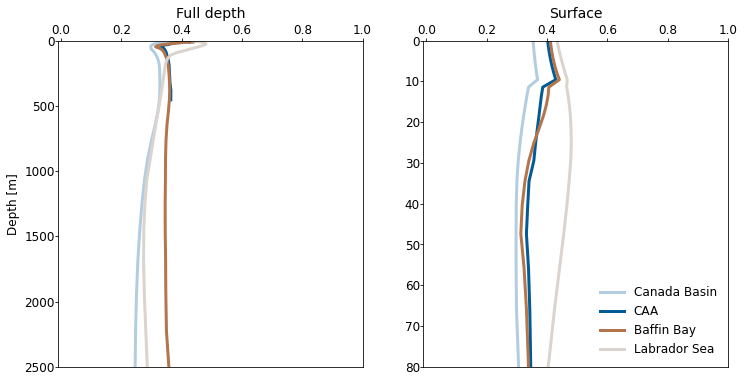

In [26]:
particle_figure(np.mean(kscav[:,:,:,:],axis=0))

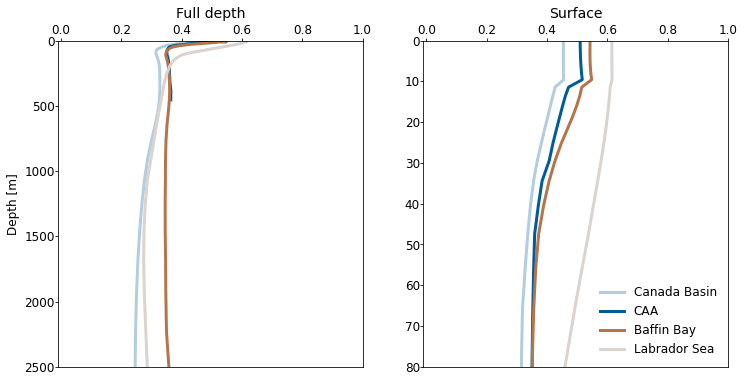

In [22]:
particle_figure(np.mean(kscav[:,:,:,:],axis=0))

In [124]:
month=8
CB_oMn, CAA_oMn, BB_oMn, LS_oMn         = calc_regional_profile(oMn[month,:,:,:]  / np.nanmax(oMn[:,:,:,:]))
CB_fpop, CAA_fpop, BB_fpop, LS_fpop     = calc_regional_profile(fpop[month,:,:,:] / np.nanmax(fpop[:,:,:,:]))
CB_fpops, CAA_fpops, BB_fpops, LS_fpops = calc_regional_profile(fpops[month,:,:,:]/ np.nanmax(fpops[:,:,:,:]))
CB_biom, CAA_biom, BB_biom, LS_biom     = calc_regional_profile(biom[month,:,:,:] / np.nanmax(biom[:,:,:,:]))

Text(0.5, 0, 'Particle abundance')

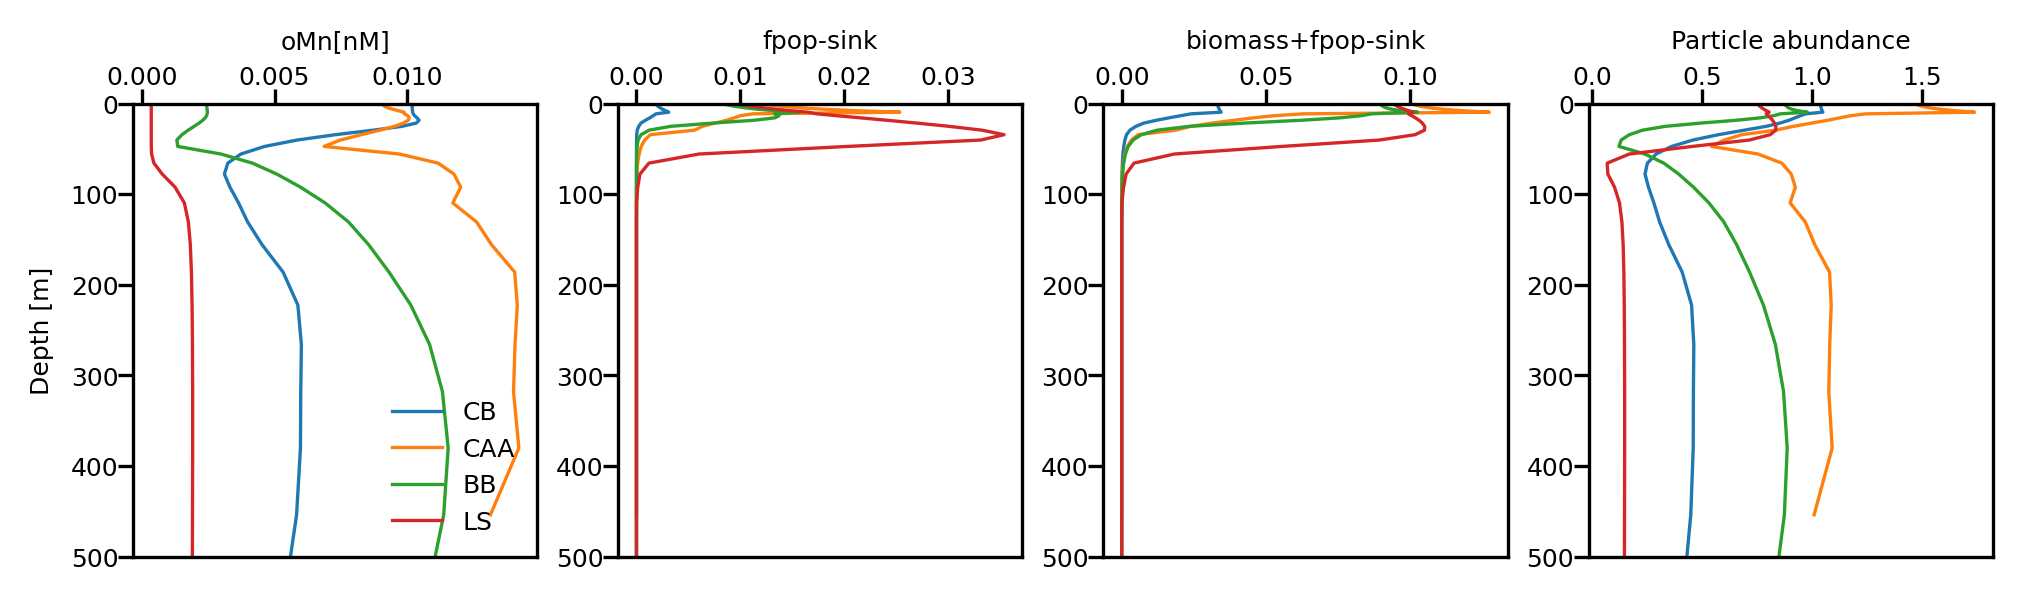

In [157]:
fig, ax = plt.subplots(1, 4, figsize=(8,2), dpi=300)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.tick_params(labelsize=6, pad=0)
    axis.xaxis.tick_top()    
    axis.xaxis.set_label_position('top') 
    axis.set_ylim(500,0);
    
ax[0].set_ylabel('Depth [m]', fontsize=6)
ax[0].plot(CB_oMn,  mesh_depth, label='CB', linewidth=0.8)
ax[0].plot(CAA_oMn, mesh_depth, label='CAA', linewidth=0.8)
ax[0].plot(BB_oMn,  mesh_depth, label='BB', linewidth=0.8)
ax[0].plot(LS_oMn,  mesh_depth, label='LS', linewidth=0.8)
ax[0].set_xlabel('oMn[nM]', fontsize=6)
ax[0].legend(loc=4, fontsize=6, frameon=False)

ax[1].plot(CB_fpops,  mesh_depth, linewidth=0.8)
ax[1].plot(CAA_fpops, mesh_depth, linewidth=0.8)
ax[1].plot(BB_fpops,  mesh_depth, linewidth=0.8)
ax[1].plot(LS_fpops,  mesh_depth, linewidth=0.8)
ax[1].set_xlabel('fpop-sink', fontsize=6)

ax[2].plot(CB_fpops + CB_biom,   mesh_depth, linewidth=0.8)
ax[2].plot(CAA_fpops + CAA_biom, mesh_depth, linewidth=0.8)
ax[2].plot(BB_fpops + BB_biom,   mesh_depth, linewidth=0.8)
ax[2].plot(LS_fpops + LS_biom,   mesh_depth, linewidth=0.8)
ax[2].set_xlabel('biomass+fpop-sink', fontsize=6)

# ax[3].plot(CB_biom,  mesh_depth, linewidth=0.8)
# ax[3].plot(CAA_biom, mesh_depth, linewidth=0.8)
# ax[3].plot(BB_biom,  mesh_depth, linewidth=0.8)
# ax[3].plot(LS_biom,  mesh_depth, linewidth=0.8)
# ax[3].set_xlabel('biomass', fontsize=6)
ax[3].plot((CB_fpops + CB_biom)/0.13 + CB_oMn/0.013,   mesh_depth, linewidth=0.8)
ax[3].plot((CAA_fpops + CAA_biom)/0.13 + CAA_oMn/0.013, mesh_depth, linewidth=0.8)
ax[3].plot((BB_fpops + BB_biom)/0.13 + BB_oMn/0.013,   mesh_depth, linewidth=0.8)
ax[3].plot((LS_fpops + LS_biom)/0.13 + LS_oMn/0.013,   mesh_depth, linewidth=0.8)
ax[3].set_xlabel('Particle abundance', fontsize=6)

In [28]:
# load and calculate annual residence time estimates from tuning runs: 
folder_base = '/data/brogalla/run_storage/Pb-tuning-202302/'
# residence_k4e5_fpop_sink015 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202302-2002-scav-fpop-sink-015/', 2002)
# residence_k4e5_fpop_sink05  = calc_annual_residence_time(f'{folder_base}Pb-tuning-202302-2002-scav-fpop-sink-1-2/', 2002)
# residence_k4e5_bio_fpop015  = calc_annual_residence_time(f'{folder_base}Pb-tuning-202302-2002-scav-biomass-fpop-015/', 2002)
residence_k4e5_bio_fpop05   = calc_annual_residence_time(f'{folder_base}Pb-tuning-202302-2002-scav-biomass-1-2-fpop/', 2002)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


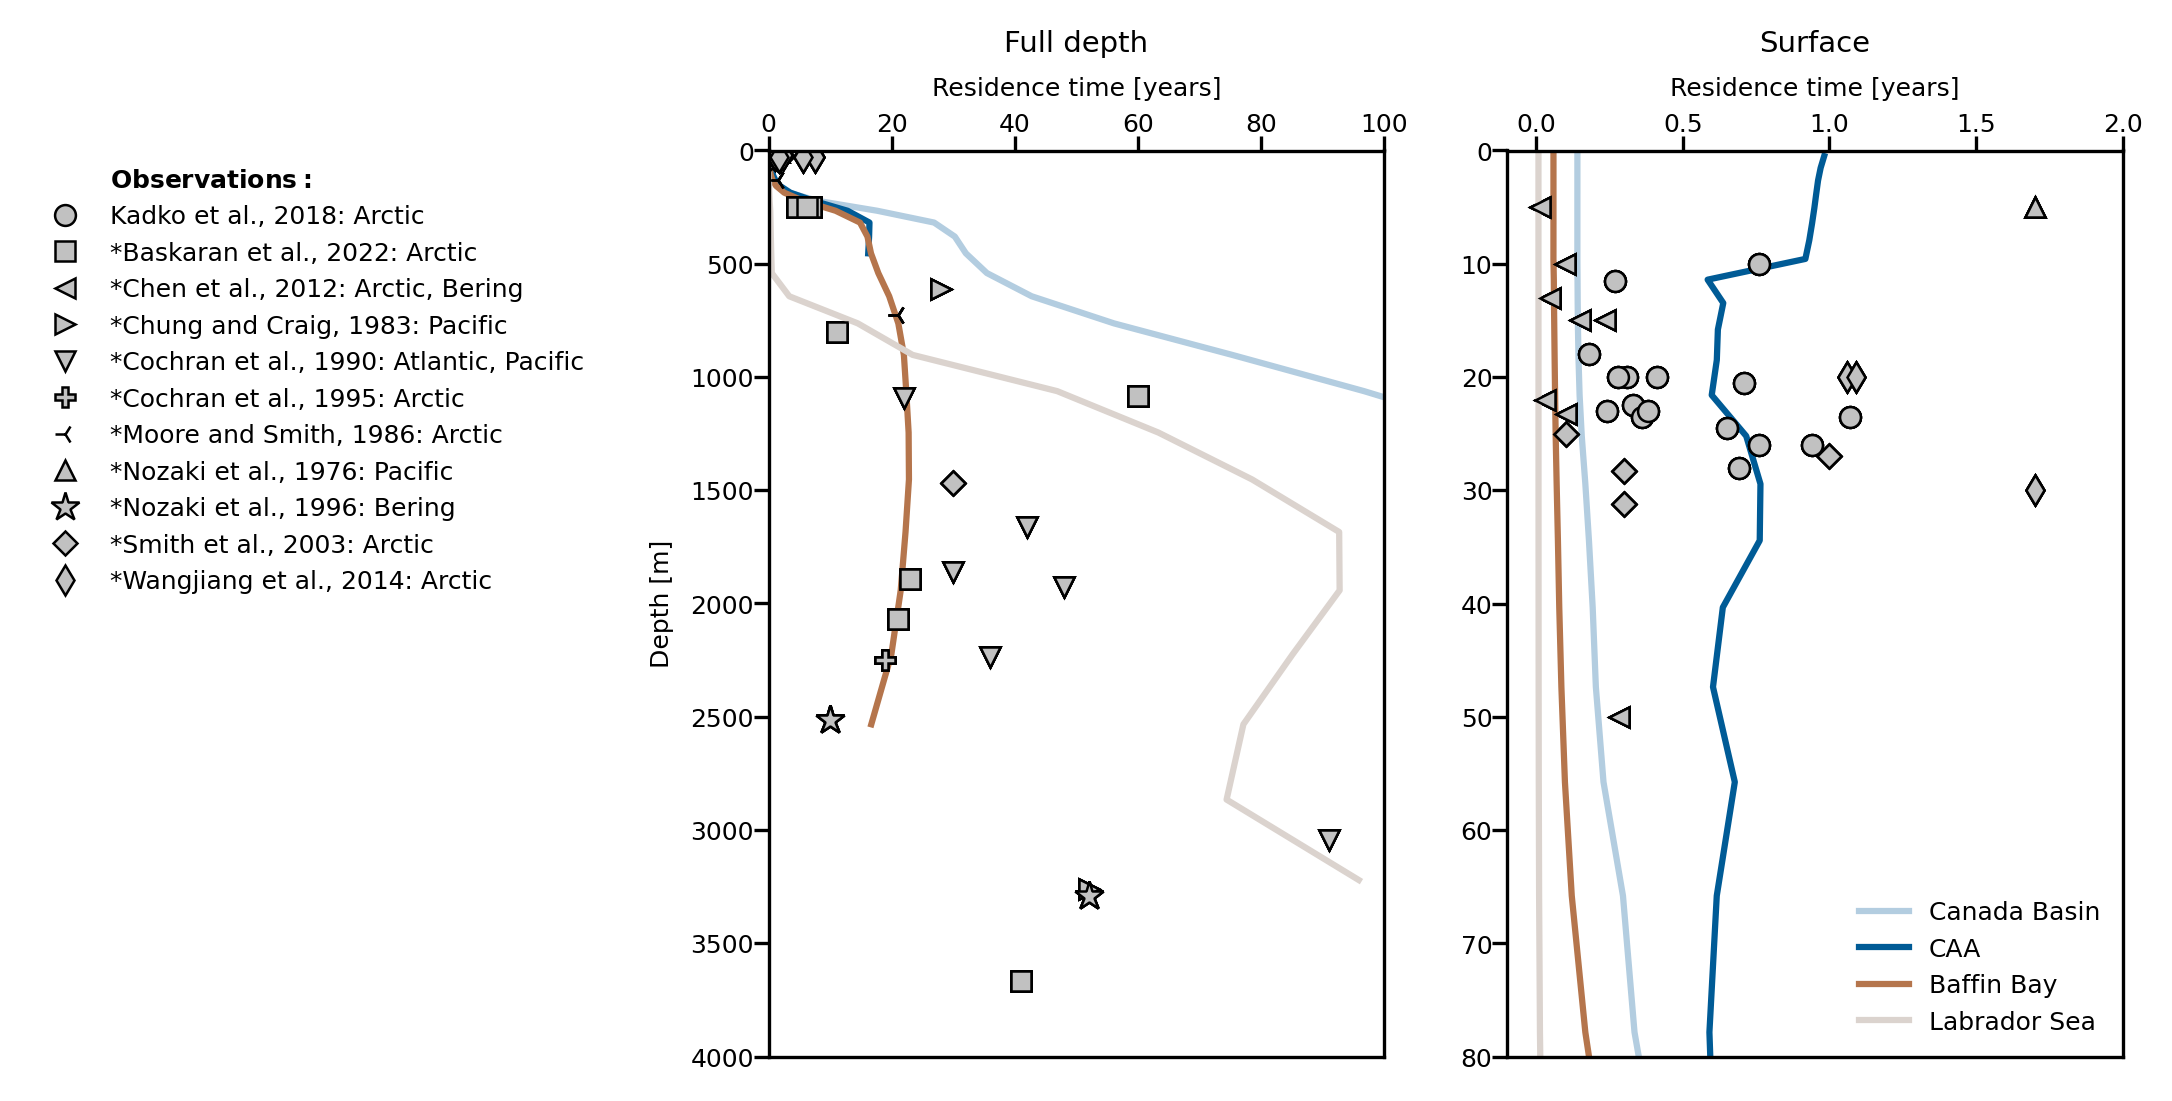

In [29]:
overview_figure(residence_k4e5_bio_fpop05)

Spatial variation in residence time

In [27]:
def plot_layer(variable, layer, vmin=0, vmax=30):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
    CB = proj1.pcolormesh(x, y, variable[:,:], cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)  
    proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], cmap=ListedColormap([land_color]), vmin=0, vmax=1)
    
    ax1.set_title(f'Depth: {mesh_depth[layer]:.1f} m', fontsize=6)
    
    # Color bar: --------------------------------------------------------------------------------
    cbaxes = fig.add_axes([0.92, 0.155, 0.02, 0.38]);
    CBar   = plt.colorbar(CB, ax=ax1, cax=cbaxes); 
    CBar.set_label('Residence time [years]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return

In [29]:
mesh_dz_array        = np.empty(residence_time_kscav5e7.shape)
mesh_dz_array[:,:,:] = mesh_dz[:,None,None]

factor = 1 # Estimated from scatter plot above
dtop = 13
depth_weighted_restime1 = np.sum(residence_time_kscav5e7[0:dtop+1,:,:]*mesh_dz_array[0:dtop+1,:,:], axis=0)*factor / mesh_depth[dtop]
# depth_weighted_restime001 = np.sum(residence_time_part001[0:dtop+1,:,:]*mesh_dz_array[0:dtop+1,:,:], axis=0)*factor / mesh_depth[dtop]
# depth_weighted_restime005 = np.sum(residence_time_part005[0:dtop+1,:,:]*mesh_dz_array[0:dtop+1,:,:], axis=0)*factor / mesh_depth[dtop]
# depth_weighted_restime015 = np.sum(residence_time_part015[0:dtop+1,:,:]*mesh_dz_array[0:dtop+1,:,:], axis=0)*factor / mesh_depth[dtop]
# depth_weighted_restime050 = np.sum(residence_time_part050[0:dtop+1,:,:]*mesh_dz_array[0:dtop+1,:,:], axis=0)*factor / mesh_depth[dtop]
# depth_weighted_restime075 = np.sum(residence_time_part075[0:dtop+1,:,:]*mesh_dz_array[0:dtop+1,:,:], axis=0)*factor / mesh_depth[dtop]
# depth_weighted_restime095 = np.sum(residence_time_part095[0:dtop+1,:,:]*mesh_dz_array[0:dtop+1,:,:], axis=0)*factor / mesh_depth[dtop]

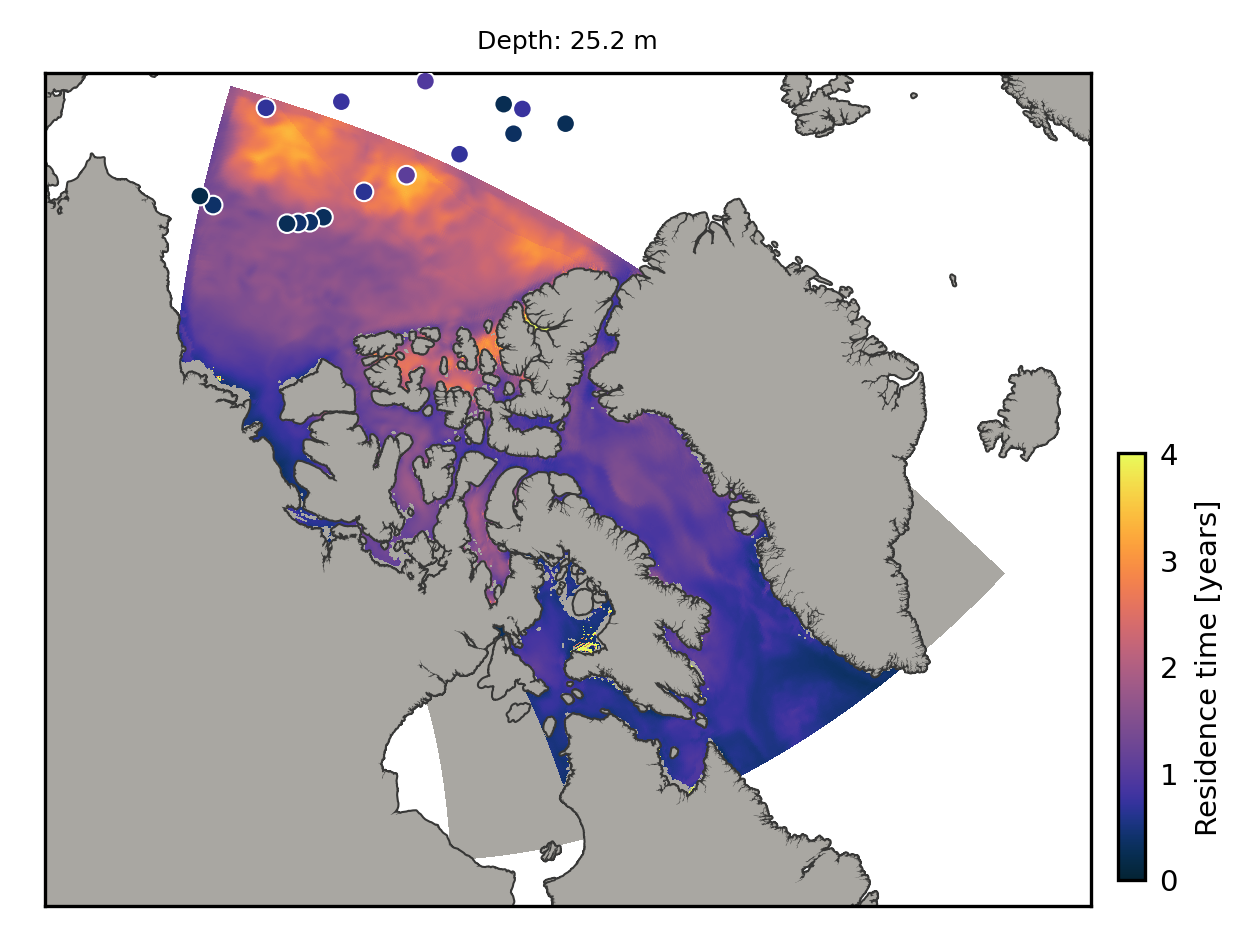

In [32]:
plot_layer(depth_weighted_restime1, 13, vmin=0, vmax=4)